In [29]:
import numpy as np
import sys
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def parse_index_file(filename):
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index


def load_data(dataset):
    # load the data: x, tx, allx, graph
    names = ['x', 'tx', 'allx', 'graph']
    objects = []
    for i in range(len(names)):
        with open("../gae/data/ind.{}.{}".format(dataset, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))
    x, tx, allx, graph = tuple(objects)
    test_idx_reorder = parse_index_file("../gae/data/ind.{}.test.index".format(dataset))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    return adj, features

def load_data_2(dataset): #Includes fixing isolated nodes for y
    
    # load the data: x, tx, allx, graph
    dataset = 'citeseer'
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("../gae/data/ind.{}.{}".format(dataset, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))
    
    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("../gae/data/ind.{}.test.index".format(dataset))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)

        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        ty_extended = sp.lil_matrix((len(test_idx_range_full), y.shape[1]))

        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        ty_extended[test_idx_range-min(test_idx_range), :] = ty

        tx = tx_extended
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    y        = sp.vstack((ally, ty)).tolil()
    
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))
    
    return adj, features, ty, y
    
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)


In [8]:
from __future__ import division
from __future__ import print_function

import time
import os

# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import tensorflow as tf
import numpy as np
import scipy.sparse as sp

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from gae.optimizer import OptimizerAE, OptimizerVAE
from gae.input_data import load_data
from gae.model import GCNModelAE, GCNModelVAE
from gae.preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges


# Settings

del_all_flags(tf.flags.FLAGS)

flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 32, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 16, 'Number of units in hidden layer 2.')
#flags.DEFINE_integer('hidden3', 2, 'Number of units in hidden layer 2.')
flags.DEFINE_float('weight_decay', 0., 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')

flags.DEFINE_string('model', 'gcn_ae', 'Model string.')
flags.DEFINE_string('dataset', 'cora', 'Dataset string.')
flags.DEFINE_integer('features', 1, 'Whether to use features (1) or not (0).')

flags.DEFINE_string('f', '', 'kernel')

#model_str = FLAGS.model
#dataset_str = FLAGS.dataset

model_str = 'gcn_vae'
dataset_str = 'citeseer'



# Load data
adj, features, ty, y = load_data_2(dataset_str)

# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
adj = adj_train

if FLAGS.features == 0:
    features = sp.identity(features.shape[0])  # featureless

# Some preprocessing
adj_norm = preprocess_graph(adj)

# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=())
}

num_nodes = adj.shape[0]

features = sparse_to_tuple(features.tocoo())
num_features = features[2][1]
features_nonzero = features[1].shape[0]

# Create model
model = None
if model_str == 'gcn_ae':
    model = GCNModelAE(placeholders, num_features, features_nonzero)
elif model_str == 'gcn_vae':
    model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero)

pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

# Optimizer
with tf.name_scope('optimizer'):
    if model_str == 'gcn_ae':
        opt = OptimizerAE(preds=model.reconstructions,
                          labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                      validate_indices=False), [-1]),
                          pos_weight=pos_weight,
                          norm=norm)
    elif model_str == 'gcn_vae':
        opt = OptimizerVAE(preds=model.reconstructions,
                           labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                       validate_indices=False), [-1]),
                           model=model, num_nodes=num_nodes,
                           pos_weight=pos_weight,
                           norm=norm)

# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

cost_val = []
acc_val = []


def get_roc_score(edges_pos, edges_neg, emb=None):
    
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        emb = sess.run(model.z_mean, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score, emb, labels_all


cost_val = []
acc_val = []
val_roc_score = []

adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)

    # Compute average loss
    avg_cost = outs[1]
    avg_accuracy = outs[2]

    roc_curr, ap_curr, emb, labels_all = get_roc_score(val_edges, val_edges_false)
    val_roc_score.append(roc_curr)

    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
          "train_acc=", "{:.5f}".format(avg_accuracy), "val_roc=", "{:.5f}".format(val_roc_score[-1]),
          "val_ap=", "{:.5f}".format(ap_curr),
          "time=", "{:.5f}".format(time.time() - t))

print("Optimization Finished!")

roc_score, ap_score, emb, labels_all = get_roc_score(test_edges, test_edges_false)
print('Test ROC score: ' + str(roc_score))
print('Test AP score: ' + str(ap_score))


Epoch: 0001 train_loss= 1.70812 train_acc= 0.49548 val_roc= 0.65802 val_ap= 0.68313 time= 1.94648
Epoch: 0002 train_loss= 1.40812 train_acc= 0.44066 val_roc= 0.67015 val_ap= 0.70433 time= 0.62268
Epoch: 0003 train_loss= 1.25394 train_acc= 0.36239 val_roc= 0.70139 val_ap= 0.74215 time= 0.66272
Epoch: 0004 train_loss= 1.08588 train_acc= 0.33598 val_roc= 0.74929 val_ap= 0.78731 time= 0.57585
Epoch: 0005 train_loss= 0.93126 train_acc= 0.31635 val_roc= 0.79854 val_ap= 0.82398 time= 0.65079
Epoch: 0006 train_loss= 0.81866 train_acc= 0.32401 val_roc= 0.83095 val_ap= 0.84179 time= 0.55469
Epoch: 0007 train_loss= 0.72769 train_acc= 0.35936 val_roc= 0.83660 val_ap= 0.84126 time= 0.60176
Epoch: 0008 train_loss= 0.66323 train_acc= 0.41580 val_roc= 0.82990 val_ap= 0.83311 time= 0.74921
Epoch: 0009 train_loss= 0.62901 train_acc= 0.42757 val_roc= 0.82951 val_ap= 0.83215 time= 0.63704
Epoch: 0010 train_loss= 0.62056 train_acc= 0.39018 val_roc= 0.83316 val_ap= 0.83532 time= 0.62760
Epoch: 0011 train_lo

Epoch: 0085 train_loss= 0.43655 train_acc= 0.53571 val_roc= 0.93423 val_ap= 0.94891 time= 0.60411
Epoch: 0086 train_loss= 0.43646 train_acc= 0.53583 val_roc= 0.93406 val_ap= 0.94914 time= 0.59986
Epoch: 0087 train_loss= 0.43643 train_acc= 0.53557 val_roc= 0.93365 val_ap= 0.94888 time= 0.57863
Epoch: 0088 train_loss= 0.43598 train_acc= 0.53661 val_roc= 0.93313 val_ap= 0.94851 time= 0.73216
Epoch: 0089 train_loss= 0.43573 train_acc= 0.53748 val_roc= 0.93303 val_ap= 0.94854 time= 0.55558
Epoch: 0090 train_loss= 0.43542 train_acc= 0.53716 val_roc= 0.93293 val_ap= 0.94843 time= 0.69309
Epoch: 0091 train_loss= 0.43550 train_acc= 0.53701 val_roc= 0.93262 val_ap= 0.94831 time= 0.61732
Epoch: 0092 train_loss= 0.43535 train_acc= 0.53830 val_roc= 0.93208 val_ap= 0.94814 time= 0.63184
Epoch: 0093 train_loss= 0.43521 train_acc= 0.53824 val_roc= 0.93217 val_ap= 0.94824 time= 0.64227
Epoch: 0094 train_loss= 0.43505 train_acc= 0.53867 val_roc= 0.93186 val_ap= 0.94795 time= 0.62000
Epoch: 0095 train_lo

Epoch: 0169 train_loss= 0.42761 train_acc= 0.54747 val_roc= 0.92715 val_ap= 0.94524 time= 0.66176
Epoch: 0170 train_loss= 0.42755 train_acc= 0.54824 val_roc= 0.92732 val_ap= 0.94539 time= 0.60152
Epoch: 0171 train_loss= 0.42760 train_acc= 0.54751 val_roc= 0.92695 val_ap= 0.94503 time= 0.61142
Epoch: 0172 train_loss= 0.42739 train_acc= 0.54752 val_roc= 0.92626 val_ap= 0.94450 time= 0.61749
Epoch: 0173 train_loss= 0.42740 train_acc= 0.54793 val_roc= 0.92546 val_ap= 0.94397 time= 0.59078
Epoch: 0174 train_loss= 0.42722 train_acc= 0.54799 val_roc= 0.92577 val_ap= 0.94422 time= 0.71510
Epoch: 0175 train_loss= 0.42718 train_acc= 0.54796 val_roc= 0.92688 val_ap= 0.94505 time= 0.61512
Epoch: 0176 train_loss= 0.42710 train_acc= 0.54783 val_roc= 0.92664 val_ap= 0.94483 time= 0.64574
Epoch: 0177 train_loss= 0.42708 train_acc= 0.54864 val_roc= 0.92546 val_ap= 0.94411 time= 0.59364
Epoch: 0178 train_loss= 0.42720 train_acc= 0.54840 val_roc= 0.92474 val_ap= 0.94362 time= 0.61552
Epoch: 0179 train_lo

In [77]:
roc_score

0.901359739161937

In [27]:
emb.shape

(3327, 16)

In [47]:
X_embedded = TSNE(n_components=2,  perplexity = 25).fit_transform(adj.T * emb)
#y_onehot = y.todense()
#y = np.argmax(y_onehot, axis=1)

In [22]:
y = [i[0] for i in y.tolist()]

In [41]:
np.array(X_embedded[:,0])

array([  4.1747413, -42.063644 ,  -1.5001707, ..., -30.792643 ,
        33.937668 ,  36.98339  ], dtype=float32)

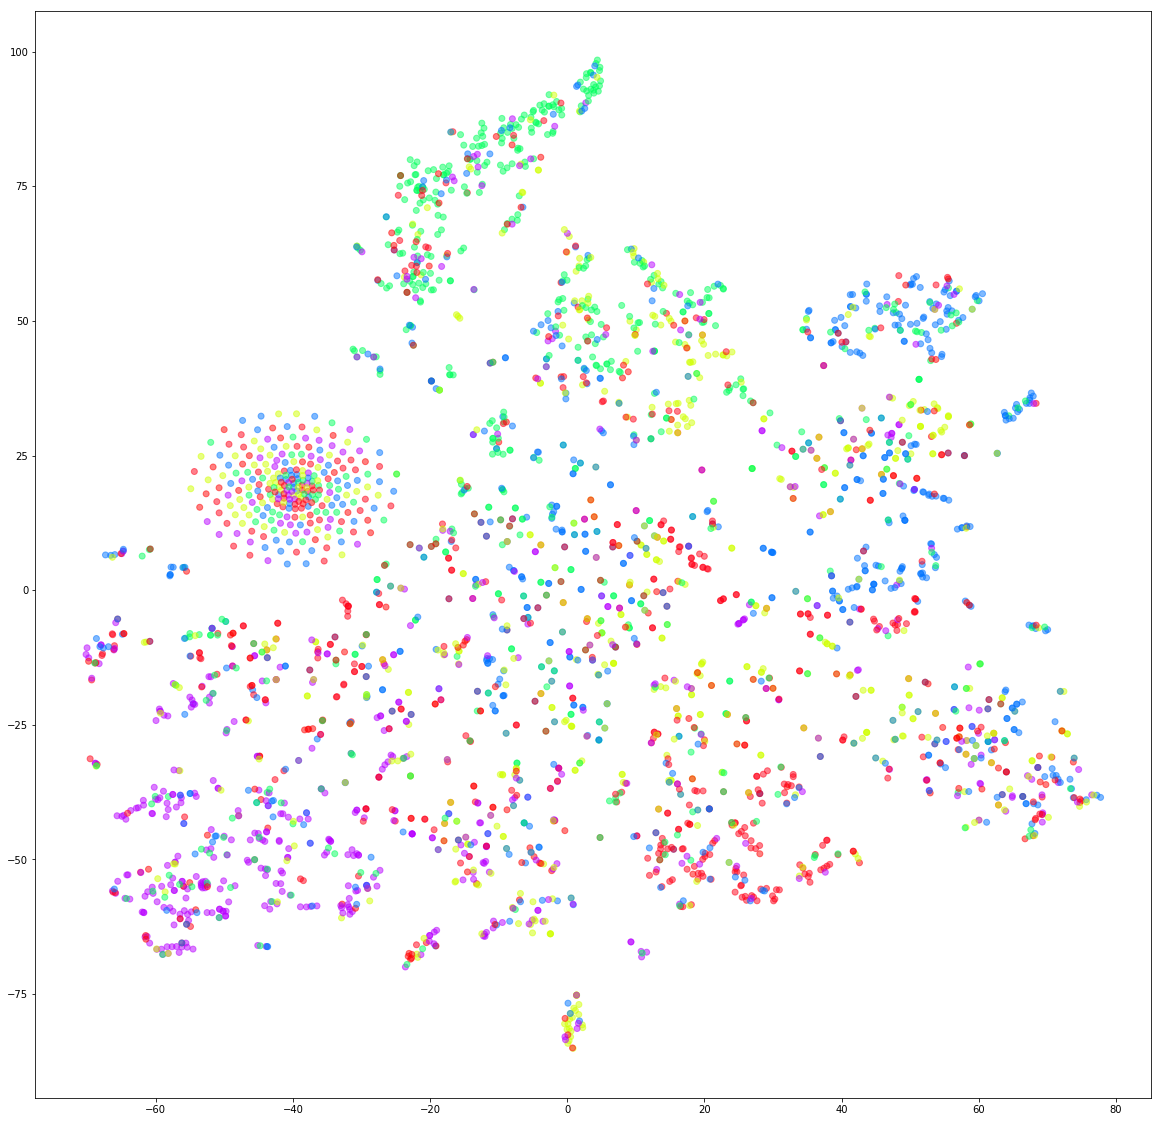

In [48]:
plt.figure(figsize = (20, 20))
plt.scatter(np.array(X_embedded[:,0]), np.array(X_embedded[:,1]), c = y, alpha = 0.5, cmap = cm.hsv)

IndexError: tuple index out of range

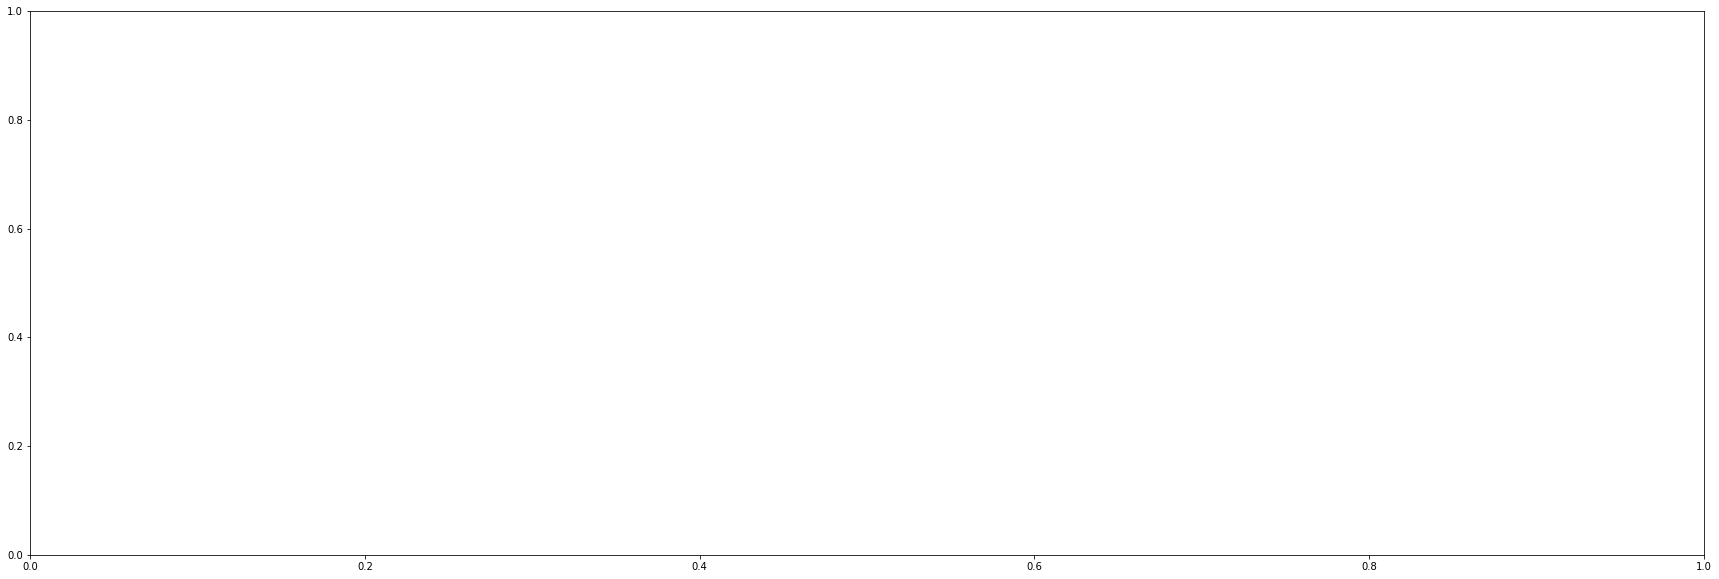

In [33]:
np.unique(y)

array([0, 1, 2, 3, 4, 5])

In [31]:
set(test_idx_range_full) - set(test_idx_range)

{2407,
 2489,
 2553,
 2682,
 2781,
 2953,
 3042,
 3063,
 3212,
 3214,
 3250,
 3292,
 3305,
 3306,
 3309}

In [25]:
len(test_idx_range_full)

1015

In [27]:
tx.shape

(1015, 3703)

In [50]:
tx

<1015x3703 sparse matrix of type '<class 'numpy.float64'>'
	with 31992 stored elements in LInked List format>

In [44]:
x

<120x3703 sparse matrix of type '<class 'numpy.float32'>'
	with 3778 stored elements in Compressed Sparse Row format>

In [59]:
ty.shape

(1015, 6)

In [60]:
y.shape

(120, 6)